In [1]:
import math
from tabulate import tabulate
from pingouin import qqplot
from scipy.stats import kstest, shapiro, anderson, jarque_bera
from statsmodels.stats.diagnostic import lilliefors

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=42)
size = 100

exp_sample = np.random.exponential(scale=1.0, size=size)
norm_sample = np.random.normal(loc=0.0, scale=1.0, size=size)
sample_df = pd.DataFrame([[e, n] for e, n in zip(exp_sample, norm_sample)],
                         columns=['exponential', 'normal'])
sample_df.head()

,exponential,normal
0,0.469268,0.087047
1,3.010121,-0.299007
2,1.316746,0.091761
3,0.912943,-1.987569
4,0.169625,-0.219672


In [3]:
def normality_tests(df, col_name, confidence_level=0.95):
    """
    Runs five normality hypothesis tests and prints their test statistics
    and p-values. Plots a histogram with a kde line and provides a q-qplot
    with confidence intervals.
    
    Parameters
    ----------
    df : pandas DataFrame
    col_name : string
        Column name to test for normality
    confidence_level : float, default 0.95
        Confidence level for q-q plot lines
    """

    def aad(ad, n):
        """
        Returns adjusted Anderson-Darling test statistic, more helpful with
        smaller sample sizes.
        """
        return ad * (1 + (0.75 / n) + (2.25 / (n ** 2)))

    def aad_pvalue(aad):
        """
        Calculating the p-value is not natively supported in the scipy library
        for the Anderson-Darling test statistic. For ease of comparison, the
        p-value is calculated using the approach identified from
        'Goodness-of-Fit Techniques' by R.B. D’Augostino and M.A. Stephens:
        https://www.spcforexcel.com/knowledge/basic-statistics/anderson-darling-test-for-normality#p_value
        """
        if aad >= 0.6:
            return math.exp(1.2937 - (5.709 * aad) + (0.0186 * aad ** 2))
        elif aad >= 0.34:
            return math.exp(0.9177 - (4.279 * aad) - (1.38 * aad ** 2))
        elif aad >= 0.2:
            return 1 - math.exp(-8.318 + (42.796 * aad) - (59.938 * aad ** 2))
        else:
            return 1 - math.exp(-13.436 + (101.14 * aad) - (223.73 * aad ** 2))

    # hypothesis tests
    
    # kolmogrov-smirnov test
    kstest_results = kstest(df[col_name], 'norm')

    # shapiro-wilk test
    swtest_results = shapiro(df[col_name])

    # anderson-darling test
    adtest_results = anderson(df[col_name])
    aad_stat = aad(adtest_results.statistic, len(df[col_name]))   # adjusted ad stat

    # lilliefors test
    lf_results = lilliefors(df[col_name])

    # jarque-bera test
    jb_results = jarque_bera(df[col_name])

    test_names = ['shapiro-wilk', 'kolmogrov-smirnov', 'anderson-darling', 'lilliefors', 'jarque-bera']
    test_index = ['statistic', 'p-value']
    test_results = np.array([
        [swtest_results.statistic, kstest_results.statistic, aad_stat, lf_results[0], jb_results.statistic],
        [swtest_results.pvalue, kstest_results.pvalue, aad_pvalue(aad_stat), lf_results[1], jb_results.pvalue]
    ])
    
    print(tabulate(pd.DataFrame(data=test_results, columns=test_names, index=test_index),
                   headers='keys', floatfmt='.4f', tablefmt='rounded_outline'))

    # plots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3.5))
    
    # histogram
    ax[0].set_title(f"{col_name} Distribution")
    sns.histplot(data=df, x=col_name, kde=True, ax=ax[0])
    
    # q-q plot
    ax[1].set_title('Q-Q Plot')
    qqplot(df[col_name], dist='norm', confidence=confidence_level, s=5, alpha=0.25, ax=ax[1])
    sns.despine(top=True, right=True)
    plt.show()

╭───────────┬────────────────┬─────────────────────┬────────────────────┬──────────────┬───────────────╮
│           │   shapiro-wilk │   kolmogrov-smirnov │   anderson-darling │   lilliefors │   jarque-bera │
├───────────┼────────────────┼─────────────────────┼────────────────────┼──────────────┼───────────────┤
│ statistic │         0.8360 │              0.5022 │             4.9236 │       0.1615 │       53.7240 │
│ p-value   │         0.0000 │              0.0000 │             0.0000 │       0.0010 │        0.0000 │
╰───────────┴────────────────┴─────────────────────┴────────────────────┴──────────────┴───────────────╯


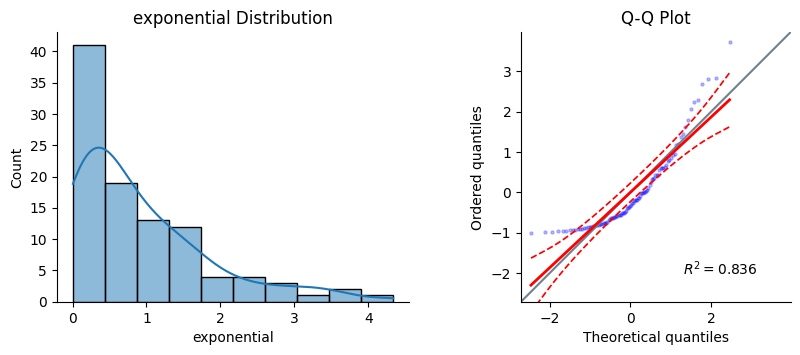

╭───────────┬────────────────┬─────────────────────┬────────────────────┬──────────────┬───────────────╮
│           │   shapiro-wilk │   kolmogrov-smirnov │   anderson-darling │   lilliefors │   jarque-bera │
├───────────┼────────────────┼─────────────────────┼────────────────────┼──────────────┼───────────────┤
│ statistic │         0.9887 │              0.0709 │             0.3307 │       0.0574 │        0.8881 │
│ p-value   │         0.5616 │              0.6702 │             0.5134 │       0.5772 │        0.6414 │
╰───────────┴────────────────┴─────────────────────┴────────────────────┴──────────────┴───────────────╯


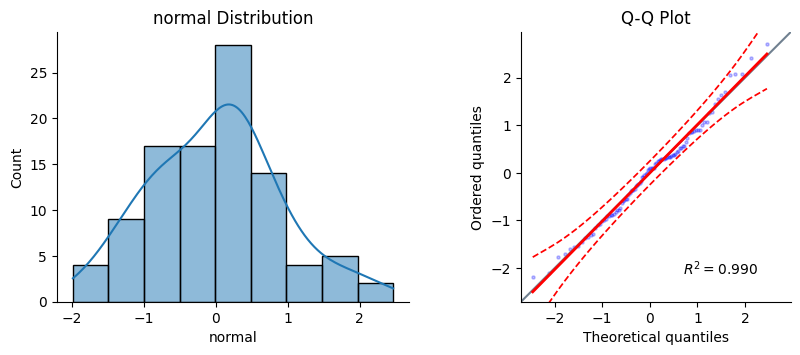

In [4]:
normality_tests(sample_df, 'exponential')
normality_tests(sample_df, 'normal')